# Probability of Default Modelling

One of the foundational concepts in credit risk is **Expected Loss**. Expected loss (EL) is a way to calculate and measure potential losses a lender anticipates across a portfolio over a given time. EL is a key metric used in credit risk management, capital planning, and pricing decisions [(CFI, Kelly Bailey)](https://corporatefinanceinstitute.com/resources/career-map/sell-side/risk-management/expected-loss-definition-calculation-importance/).

Expected Loss is commonly expressed as:

`EL = PD x LGD x EAD`

Where:
- `PD (Probability of Default)`: Likelihood that a borrower defaults
- `LGD (Loss Given Default)`: Proportion of exposure lost if default occurs
- `EAD (Exposure at Default)`: The total exposure at the time of default 

This project will focus on **Probability of Default (PD)**. 

Probability of Default (PD), tells us the likelihood that a borrower will default on their obligations. In practical terms, it answers the question: *What is the probability that a given borrower will default on their loan?*

Accurate PD estimations are central to credit risk modelling, as it has a direct affect on expected loss calculations, credit management decisions, and regulatory capital requirements.

**Dataset:**

The dataset used in this project simulates credit bureau data, and can be found on [Kaggle](https://www.kaggle.com/datasets/laotse/credit-risk-dataset/data) along with the datasets feature dictionary.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, brier_score_loss
from sklearn.calibration import calibration_curve
from feature_engine.imputation import AddMissingIndicator, MeanMedianImputer
from feature_engine.encoding import WoEEncoder

df = pd.read_csv('data/credit_risk_dataset.csv')

df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


In [3]:
df.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,32581.000000,3.258100e+04,31686.000000,32581.000000,29465.000000,32581.000000,32581.000000,32581.000000
mean,27.734600,6.607485e+04,4.789686,9589.371106,11.011695,0.218164,0.170203,5.804211
std,6.348078,6.198312e+04,4.142630,6322.086646,3.240459,0.413006,0.106782,4.055001
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.850000e+04,2.000000,5000.000000,7.900000,0.000000,0.090000,3.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,30.000000,7.920000e+04,7.000000,12200.000000,13.470000,0.000000,0.230000,8.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,1.000000,0.830000,30.000000


In [4]:
# default to non-default observation distribution
label_counts = df['loan_status'].value_counts()
label_counts

loan_status
0    25473
1     7108
Name: count, dtype: int64

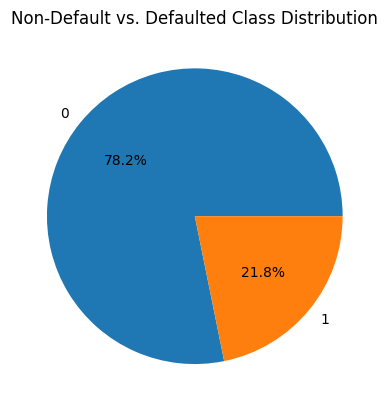

In [5]:
# visual distribution representation
labels = [0, 1]

plt.pie(label_counts, labels=labels, autopct='%1.1f%%')
plt.title('Non-Default vs. Defaulted Class Distribution')
plt.show()

In [6]:
df.dtypes

person_age                      int64
person_income                   int64
person_home_ownership          object
person_emp_length             float64
loan_intent                    object
loan_grade                     object
loan_amnt                       int64
loan_int_rate                 float64
loan_status                     int64
loan_percent_income           float64
cb_person_default_on_file      object
cb_person_cred_hist_length      int64
dtype: object

In [7]:
df[['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']].head()

,person_home_ownership,loan_intent,loan_grade,cb_person_default_on_file
0,RENT,PERSONAL,D,Y
1,OWN,EDUCATION,B,N
2,MORTGAGE,MEDICAL,C,N
3,RENT,MEDICAL,C,N
4,RENT,MEDICAL,C,Y


`cb_person_default_on_file` is the only feature that can be altered without causing any potential leakage at this current stage. Since the values are in a 'Y', 'N' format, we can change this to a binary 1 and 0 format, using mapping.

In [8]:
# historical default column mapping: Y = 1, N = 0
defualt_history_map = {'Y': 1, 'N': 0}
df['cb_person_default_on_file'] = df['cb_person_default_on_file'].map(defualt_history_map)

df[['cb_person_default_on_file']].head()

,cb_person_default_on_file
0,1
1,0
2,0
3,0
4,1


### Missing Data: Imputation & Indicators

In [9]:
df.isnull().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

There are two features with missing data:
- `person_emp_length`: Employee length in years
- `loan_int_rate`: Interest rate assigned to a loan

**Strategy:**

The duration of someones employment is a relevant indicator of a borrowers financial stability and repayment capacity. The absence of recorded employment information may itself carry some predictive value; reflecting unemployment or informal employment. To capture this information, a missing indicator column is will be added, flagging observations where employment employment length is missing. Missing values in `person_emp_length` are then imputed with *0*, assuming no employment if missing.

A missing indicator column will be added for `loan_int_rate`, and missing values will be filled by the *global median interest rate*. Here, the median is preferred over the mean, as interest rates may contain outliers; while the median value provides central tendency estimate. However, it's important to note that the loan_int_rate column could potentially cause label leakage; since interest rate is directly related to the risk of loan due to the pricing policy.

In [10]:
# split features and targets
X = df.drop(columns=['loan_status'])
y = df['loan_status']

# train and testing set split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 

In [11]:
# missing indicators
missing_indicator = AddMissingIndicator(variables=['person_emp_length', 'loan_int_rate'])
X_train = missing_indicator.fit_transform(X_train)
X_test = missing_indicator.transform(X_test)

X_train[['person_emp_length', 'person_emp_length_na', 'loan_int_rate', 'loan_int_rate_na']].head()

,person_emp_length,person_emp_length_na,loan_int_rate,loan_int_rate_na
32377,2.0,0,11.09,0
1338,0.0,0,16.45,0
7047,3.0,0,13.11,0
8225,6.0,0,7.88,0
7178,3.0,0,12.54,0


In [12]:
# impute missing loan_int_rate data with gloabal median value
median_imputation = MeanMedianImputer(variables=['loan_int_rate'], imputation_method='median')
X_train = median_imputation.fit_transform(X_train)
X_test = median_imputation.transform(X_test)

X_train.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,person_emp_length_na,loan_int_rate_na
32377,64,46000,RENT,2.0,PERSONAL,C,4800,11.09,0.10,1,24,0,0
1338,26,26000,OWN,0.0,DEBTCONSOLIDATION,E,8500,16.45,0.33,0,3,0,0
7047,23,51000,MORTGAGE,3.0,PERSONAL,C,16000,13.11,0.31,1,3,0,0
8225,22,56004,MORTGAGE,6.0,MEDICAL,A,6000,7.88,0.11,0,4,0,0
7178,24,79000,RENT,3.0,PERSONAL,C,7000,12.54,0.09,0,3,0,0


In [13]:
# fill missing employed length with 0; Assume unemployment
X_train['person_emp_length'] = X_train['person_emp_length'].fillna(0)
X_test['person_emp_length'] = X_test['person_emp_length'].fillna(0)

X_train.head() 

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,person_emp_length_na,loan_int_rate_na
32377,64,46000,RENT,2.0,PERSONAL,C,4800,11.09,0.10,1,24,0,0
1338,26,26000,OWN,0.0,DEBTCONSOLIDATION,E,8500,16.45,0.33,0,3,0,0
7047,23,51000,MORTGAGE,3.0,PERSONAL,C,16000,13.11,0.31,1,3,0,0
8225,22,56004,MORTGAGE,6.0,MEDICAL,A,6000,7.88,0.11,0,4,0,0
7178,24,79000,RENT,3.0,PERSONAL,C,7000,12.54,0.09,0,3,0,0


In [14]:
X_train.isnull().sum()

person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
person_emp_length_na          0
loan_int_rate_na              0
dtype: int64

### Categorical Column Handling: Weight of Evidence

In [15]:
X_train.dtypes

person_age                      int64
person_income                   int64
person_home_ownership          object
person_emp_length             float64
loan_intent                    object
loan_grade                     object
loan_amnt                       int64
loan_int_rate                 float64
loan_percent_income           float64
cb_person_default_on_file       int64
cb_person_cred_hist_length      int64
person_emp_length_na            int64
loan_int_rate_na                int64
dtype: object

There are three remianing categorical columns in the dataset:
- `person_home_ownership`: Type of ownership (e.g., Rent, Mortgage, Own)
- `loan_intent`: Intention behind the loan
- `loan_grade`: Grade of the loan

All of which could be useful for predicting probability of default. In particular, the `loan_grade` is an especially important feature for PD modelling, as loan grades explicitly reflects the borrowers risk factor. We can intuitively assume loans graded 'A' are to be safer (lower risk) than 'B', 'B' safer than 'C' and so on. 

So a strategy is needed to convert these categorical features into numerical form, while preserving their underlying risk information. This can be done using [Weight of Evidence (WoE)](https://www.listendata.com/2015/03/weight-of-evidence-woe-and-information.html) enconding.

WoE is a statistical method that calculates and measures both the direcetion and magnitude of a categorys relationship with a target vairable, which in this case is `loan_status`. This allows categorical values to be transformed into numerical representations, reflecting their relative risk to default, rather than treating all categories as unrelated (e.g., one-hot encdoing).

For this project, WoE is defined as:
$$
WoE = ln(\frac{\text{Distribution of non-defaults}}{\text{Distribution of Defaults}})
$$

Where:
- **Positive** WoE indicates a category with a higher distribution of non-defaulted loans
- **Negative** WoE indicates a category with a higher distribution of defaulted loans  

So, we can assume a group of loans graded 'A' would have a negative WoE; having a low amount of defaulted loans, Where a group of loans graded 'F' would have a positive WoE; having a high amount of defaulted loans.

In [16]:

X_train['loan_grade'].unique()

array(['C', 'E', 'A', 'B', 'D', 'F', 'G'], dtype=object)

In [17]:
# WoE encoding on categorical features
woe = WoEEncoder(variables=['loan_grade', 'loan_intent', 'person_home_ownership'])
X_train = woe.fit_transform(X_train, y_train)
X_test = woe.transform(X_test)

# check loan_grade WoE values are monotonic
X_train['loan_grade'].unique()

array([-0.06238928,  1.84851868, -0.91882296, -0.35742352,  1.63956267,
        2.19048589,  5.17345043])

In [18]:
X_train.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,person_emp_length_na,loan_int_rate_na
32377,64,46000,0.505048,2.0,-0.103537,-0.062389,4800,11.09,0.10,1,24,0,0
1338,26,26000,-1.205894,0.0,0.363512,1.848519,8500,16.45,0.33,0,3,0,0
7047,23,51000,-0.671843,3.0,-0.103537,-0.062389,16000,13.11,0.31,1,3,0,0
8225,22,56004,-0.671843,6.0,0.250441,-0.918823,6000,7.88,0.11,0,4,0,0
7178,24,79000,0.505048,3.0,-0.103537,-0.062389,7000,12.54,0.09,0,3,0,0


## Modelling: Logisitc Regression

The most commonly used model for PD estimation is *logistic regression*. This is mainly due to its simplicity, and interpretability. Logistic regression provides stable probability estimates, is easy to audit and explain, and aligns well with regulatory and business requirements in credit risk modelling.

### Cross-validation

In [19]:
# logistic regression model
model = LogisticRegression(max_iter=1000)

# cross-validate using stratifiedkfold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv = cross_val_score(model, X_train, y_train, cv=skf, scoring='neg_brier_score', n_jobs=-1)
cv_results = -cv

print(cv_results)
print(f'Cross-validation Average Brier Score: {cv_results.mean():.3f}')

[0.1081676  0.11159987 0.11184798 0.1109386  0.10885832]
Cross-validation Average Brier Score: 0.110


**Baseline Brier Score**

The Baseline Brier Score, formally known as the [Brier Score of Reference](https://en.wikipedia.org/wiki/Brier_score#Brier_skill_score_(BSS)) (or BSref), is a naive model that uses the frequency of a given class to make a constant default rate prediction for every observation. As this reference model does not use any feature information and relies solely on class frequency, it represents a 'no-skill benchmark'. Providing a useful baseline which more complex models can be evaluated against. Any predictive models should aim to improve upon this baseline by reducing its calculated squared probability error. 

The Baseline Brier Score is calculated as:

$$
BS_{ref} = \frac{1}{N}\sum_{t=1}^N(\overline{o} - o_t)^2
$$

In [20]:
# training-set baseline brier score
baseline_brier = y_train.mean() * (1 - y_train.mean())**2 + (1 - y_train.mean()) * (0 - y_train.mean())**2

# comparison between cv brier score and baseline
print(f'Baseline Brier: {baseline_brier:.3f}')
print(f'Model CV Brier: {cv_results.mean():.3f}')

Baseline Brier: 0.170
Model CV Brier: 0.110


### Full Training & Testing

In [21]:
# model training
model.fit(X_train, y_train)

# prediction - second column for default predictions
y_prob = model.predict_proba(X_test)[:, 1]

c:\Users\touns\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Validation

In [22]:
# validation
roc_auc = roc_auc_score(y_test, y_prob)
brier_score = brier_score_loss(y_test, y_prob)

print(f'AUC-ROC Score: {roc_auc:.3f}')
print(f'Brier Score: {brier_score:.3f}')

AUC-ROC Score: 0.849
Brier Score: 0.113


**Brier Skill Score**

Using both the model's Brier score and the baseline Brier score, we are able to calculate the [Brier Skill Score](https://en.wikipedia.org/wiki/Brier_score#Brier_skill_score_(BSS)) (BSS). BSS measures how much a model improves upon the baseline (BSref), by comparing the model's Brier score to the the no-skill refernce model (baseline). A positive BSS would indicate that the model was able to reduce the sqaured probability error relative to the baseline, while a negative BSS indicates that the model worse than the no-skill benchmark.

Brier Skill Score calculated as:
$$
BSS = 1 - \frac{BS_{model}}{BS_{ref}}
$$

In [23]:
# brier skill score
bss = 1 - brier_score / baseline_brier
print(f'BSS: {bss:.3f}')

BSS: 0.336


**Calibration Curve**

The [calibration curve](https://encord.com/glossary/calibration-curve/) compares predicted probabilities to observed default rates by grouping predictions into bins and plotting the average predicted probability against the actual default frequency.

A well calibrated model will closely follow the diagonal line (perfectly calibrated line), indicating that predicted probabilities accurately reflect observed outcomes. Deviations from this line highlight areas where the model overestimates or underestimates default risk rates.


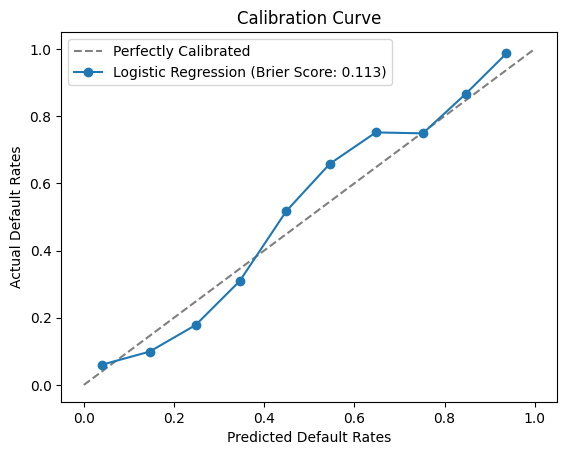

In [24]:
# calibration curve
prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10)

plt.plot([0, 1], [0, 1], linestyle='--', c='grey', label='Perfectly Calibrated')
plt.plot(prob_pred, prob_true, marker='o', label='Logistic Regression (Brier Score: 0.113)')
plt.title('Calibration Curve')
plt.xlabel('Predicted Default Rates')
plt.ylabel('Actual Default Rates')
plt.legend(loc='best')
plt.show()

**Findings**

Model results:
- AUC-ROC: 0.849
- Brier Score: 0.113
- Brier Skill Score (BSS): 0.336

The model performed quite well; achieving an AUC of ~0.85 indicates the model's discriminatory ability, being able to effectivley distinguish between defaulting and non-defaulting oberservations in the test set. This is supported by a Brier score of 0.113, which is roughly a 34% reduction in squared probability errors comapred to the baseline. The calibration curve shows that the model tends to slightly underestimates the default risk for predicted probabilities in the 0.2-0.4 range, and slightly overestimates risk between approximatley 0.5-0.7. For higher predicted probabilites (80%+), the model tends to closely align with the observed rates. Overall, the calibration curve follows the perfectly calibrated line closely, indicating that the model is generally well calibrated. This is consistent with the Brier and AUC-ROC scores. 

## Comparison: Potential Label Leakage

Earlier, I mentioned the possibility of the `loan_int_rate` feature causing potential label leakage. Interest rates are usually a direct factor and indicator of the level of risk associated with that loan [(CFI)](https://corporatefinanceinstitute.com/resources/commercial-lending/interest-rate/). Meaning that interest rate can be viewed as an already risk-adjusted price, rather than a purely borrower derived characteristic (like employment length). 

Including this feature introduces the potential risk that the model learns from the lender's pricing decision, rather than learning the underlying factors that drive default risk. In practice, PD estimation typically comes before pricing, meaning the interest rate would not be available during PD modelling.

So, to better reflect a realistic PD modelling scenario, and to assess the impact of this potential leakage, a second model is trained and tested on the same dataset with the `laon_int_rate` feature removed. The performance of this model will then be compared against the original model to evaluate whether excluding the interest rate affects the predictive performance of the model.


In [25]:
# drop interest rate feature from training and testing sets
X_train_no_ir = X_train.drop(columns=['loan_int_rate'])
X_test_no_ir = X_test.drop(columns=['loan_int_rate'])

In [26]:
# modelling - without interest rate feauture
model_no_ir = LogisticRegression(max_iter=1000)

# train & test
model_no_ir.fit(X_train_no_ir, y_train)
y_prob_no_ir = model_no_ir.predict_proba(X_test_no_ir)[:, 1]

c:\Users\touns\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [27]:
# validate model
roc_auc_no_ir = roc_auc_score(y_test, y_prob_no_ir)
brier_score_no_ir = brier_score_loss(y_test, y_prob_no_ir)
bss_no_ir = 1 - brier_score_no_ir / baseline_brier

print(f'AUC-ROC Score (No interest rates): {roc_auc_no_ir:.3f}')
print(f'Brier Score (No interest rates): {brier_score_no_ir:.3f}')
print(f'BSS (No interest rates): {bss_no_ir:.3f}')

AUC-ROC Score (No interest rates): 0.852
Brier Score (No interest rates): 0.112
BSS (No interest rates): 0.339


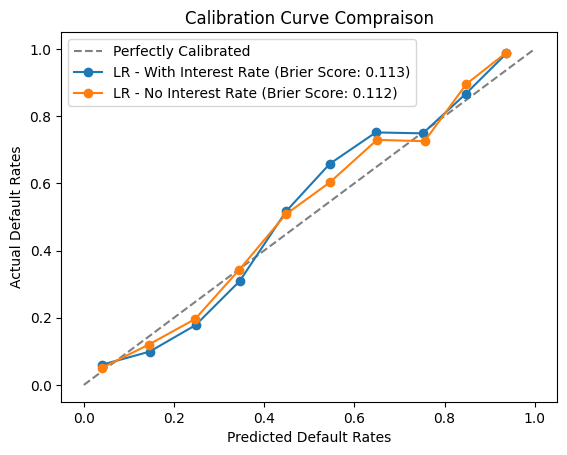

In [ ]:
# calibration curve comparison
prob_true_no_ir, prob_pred_no_ir = calibration_curve(y_test, y_prob_no_ir, n_bins=10)

plt.plot([0, 1], [0, 1], linestyle='--', c='grey', label='Perfectly Calibrated')
plt.plot(prob_pred, prob_true, marker='o', label='LR - With Interest Rate (Brier Score: 0.113)')
plt.plot(prob_pred_no_ir, prob_true_no_ir, marker='o', label='LR - No Interest Rate (Brier Score: 0.112)')
plt.title('Calibration Curve Compraison')
plt.xlabel('Predicted Default Rates')
plt.ylabel('Actual Default Rates')
plt.legend(loc='best')
plt.savefig('figures/compared_curve.png')
plt.show()
plt.close()

**Findings**

Comparison results: 
| Metric      | With Interest Rate | Without Interest Rate |
| ----------- | -----------------: | --------------------: |
| AUC-ROC     | 0.849 | 0.852 | 
| Brier Score | 0.113 | 0.112 |
| BSS         | 0.336 | 0.339 |

Desipite removing a potentially strong predictive feature such as interest rate, the trained wihtout it performs marginally better. The calibration curves for both models follow a similar pattern; underestimating and overestimating in the same probability ranges. However, the model excluding `loan_int_rate` appears to be slightly better calibrated overall, suggesting that the interest rate does not necessarily improve probability estimation. A possible explanation is that the iterest rate is highly correlated with another feature in the dataset, like`loan_grade`. Since loan grade already reflect a borrowers potential risk, the interest rate may add little independent information and instead adds noise.

In [31]:
# check correlation between interest rate and loan grade
interest_grade_corr = X_train['loan_int_rate'].corr(X_train['loan_grade'])
print(f'Correlation between loan_int_rate and loan_grade: {interest_grade_corr:.2f}')

Correlation between loan_int_rate and loan_grade: 0.81


## Conclusion

In this PD Modelling project:

- A logistic regression model was developed, achieving a Brier score of 0.112, reducing the squared error of the baseline (BSref) by ~34%, and an AUC-ROC of 0.852.
- A comparison was performed between a model trained with the interest rate feature and one without. 
    - Found that the model trained excluding interest rate performed marginally better; suggesting that interest rate may provide limited additional information due to overlap with other risk related features such as loan grade.
- WoE encoding was explored as a method for transforming categorical columns to numerical while preserving their relationship with default risk.
- Explored the uses of WoE
- Model performance was evaluated using both discrimination and calibration metrics, including: AUC-ROC, Brier Score (with BSS and BSref), and calibration curves. 

**Future work:**
- Explore other models commonly used in PD modelling; such as tree-based models (e.g., random forests). 
- Investigate how PD estimates can be applied to other areas such as loan grading and pricing.